<span style="font-width:bold; font-size: 3rem; color:#333;">- Batch Inference</span>

In [1]:
import sys
from pathlib import Path

#Find root directory
root_dir = Path().absolute()
if root_dir.parts[-2:] == ('notebooks', 'algae_bloom'):
    root_dir = Path(*root_dir.parts[:-2])
root_dir = str(root_dir)

print(f"Root dir: {root_dir}")

# Add the root directory to the `PYTHONPATH` 
if root_dir not in sys.path:
    sys.path.append(root_dir)
    print(f"Added the following directory to the PYTHONPATH: {root_dir}")

Root dir: /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-project
Added the following directory to the PYTHONPATH: /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-project


## 🌐 Imports

In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 12, 21, 21, 42, 54, 97386)

## 🌳 Connect to Hopsworks and get variables from Hopsworks secret </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

#Get the dictionary with all batch locations
bath_locations_json = secrets.get_secret("BATH_LOCATIONS_JSON").value
bath_locations = json.loads(bath_locations_json)
print(bath_locations)

2025-12-21 21:42:56,696 INFO: Initializing external client
2025-12-21 21:42:56,697 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-12-21 21:42:57,677 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-12-21 21:42:58,528 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286295
[{'bath_location': 'Bergabadet', 'latitude': 59.057008, 'longitude': 17.440774}, {'bath_location': 'Bränningestrand', 'latitude': 59.148617, 'longitude': 17.6674}, {'bath_location': 'Eklundsnäsbadet', 'latitude': 59.16883, 'longitude': 17.59184}, {'bath_location': 'Farstanäsbadet', 'latitude': 59.096884, 'longitude': 17.65387}, {'bath_location': 'Mälarbadet', 'latitude': 59.222657, 'longitude': 17.611886}, {'bath_location': 'Nya Malmsjöbadet', 'latitude': 59.234823, 'longitude': 17.536534}, {'bath_location': 'Näsets udde(Glashyttan)', 'latitude': 59.158419, 'longitude': 17.66072}, {'bath_location': 'Underåsbadet', 'latitude': 59.26482, 'longitude': 17.536534}, {'bath_location': 'Åbynäsbadet', 'latitude': 59.018397, 'longitude': 17.619576}]


## ⚓︎ Download model from model registry

In [5]:
mr = project.get_model_registry()

#Retrieve model from Hopsworks
model_version = 1

retrieved_model = mr.get_model(
    name="water_temperature_xgboost_model", 
    version=model_version, 
)
fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-12-21 21:43:01,236 INFO: There is no parent information


Downloading: 0.000%|          | 0/543086 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/33977 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/72623 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/45514 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/68244 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/38986 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/63752 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/122505 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/130739 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26824 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28445 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")

retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.0393394E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## ☔️ Get the weather forecast features from the feature view



In [7]:
#Select version of feature group
w_version = 1

weather_fg = fs.get_feature_group(
    name='weather',
    version=w_version,
)
batch_data = weather_fg.filter(weather_fg.formatted_time >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 


,formatted_time,alias,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,latitude,longitude
0,2025-12-24 12:00:00+00:00,Mälarbadet,-0.75,0.0,10.315115,299.248718,59.222657,17.611886
1,2025-12-25 12:00:00+00:00,Mälarbadet,1.50,0.0,13.363711,274.635376,59.222657,17.611886
2,2025-12-23 12:00:00+00:00,Mälarbadet,1.10,0.0,8.669949,48.366554,59.222657,17.611886
3,2025-12-22 12:00:00+00:00,Mälarbadet,0.95,0.0,9.826088,351.573120,59.222657,17.611886
4,2025-12-27 12:00:00+00:00,Mälarbadet,1.15,0.0,17.317459,290.695526,59.222657,17.611886
5,2025-12-26 12:00:00+00:00,Mälarbadet,2.45,0.0,11.753876,319.969788,59.222657,17.611886


## 🔮 Add lagging features for comming days using predictions  </span>


In [8]:
#Select version of feature group
BATH_TO_CODE = {"Bergabadet":0,"Bränningestrand":1,"Eklundsnäsbadet":2,"Farstanäsbadet":3, "Mälarbadet":4, "Nya Malmsjöbadet":5, "Näsets udde(Glashyttan)":6, "Underåsbadet":7, "Åbynäsbadet":8}
CODE_TO_BATH = {0:"Bergabadet", 1:"Bränningestrand", 2:"Eklundsnäsbadet", 3:"Farstanäsbadet", 4:"Mälarbadet", 5:"Nya Malmsjöbadet", 6:"Näsets udde(Glashyttan)", 7:"Underåsbadet", 8:"Åbynäsbadet"}

wt_version = 1

water_temperature_fg = fs.get_feature_group(
    name='water_temperature',
    version=wt_version,
)
batch_data = batch_data.sort_values("formatted_time").reset_index(drop=True)



batch_data_frames = []
for location_dict in bath_locations:
    bath_location = location_dict['bath_location']
    print(bath_location)

    bath_location_cat = BATH_TO_CODE[bath_location]

    #wt_df = water_temperature_fg.filter(water_temperature_fg.alias == bath_location)
    wt_df = water_temperature_fg.read()
    wt_df = wt_df[wt_df['alias'] == bath_location]
    wt_df = wt_df.sort_values("formatted_time")
    if bath_location == "Mälarbadet":
        print(wt_df)

    #print(wt_df)

    temp_batch_data = batch_data[batch_data["alias"] == bath_location].copy().reset_index(drop=True)
    temp_batch_data["alias"] = temp_batch_data["alias"].map(BATH_TO_CODE)

    for i in range (temp_batch_data.shape[0]):
        if i == 0:
            lagged1_df = wt_df[
                pd.to_datetime(wt_df["formatted_time"]).dt.date
                == (pd.to_datetime(temp_batch_data.iloc[i]["formatted_time"]).date() - datetime.timedelta(days=1))
            ]
            lagged2_df = wt_df[
                pd.to_datetime(wt_df["formatted_time"]).dt.date
                == (pd.to_datetime(temp_batch_data.iloc[i]["formatted_time"]).date() - datetime.timedelta(days=2))
            ]
            lagged3_df = wt_df[
                pd.to_datetime(wt_df["formatted_time"]).dt.date
                == (pd.to_datetime(temp_batch_data.iloc[i]["formatted_time"]).date() - datetime.timedelta(days=3))
            ]
            #print(lagged1_df)
            #print(lagged2_df)
            #print(lagged3_df)

            if not lagged1_df.empty:
                temp_batch_data.loc[i, "lagged_wt_1_day"] = lagged1_df["temp_water"].values[-1]
            else:
                temp_batch_data.loc[i, "lagged_wt_1_day"] = 'NaN'
            if not lagged2_df.empty:
                temp_batch_data.loc[i, "lagged_wt_2_days"] = lagged2_df["temp_water"].values[-1]
            else:
                temp_batch_data.loc[i, "lagged_wt_2_days"] = 'NaN'
            if not lagged3_df.empty:
                temp_batch_data.loc[i,"lagged_wt_3_days"] = lagged3_df["temp_water"].values[-1]
            else:
                temp_batch_data.loc[i, "lagged_wt_3_days"] = 'NaN'

        elif i==1:
            temp_batch_data.loc[i, "lagged_wt_1_day"] = temp_batch_data.iloc[i-1]['predicted_temp_water']
            
            lagged2_df = wt_df[pd.to_datetime(wt_df["formatted_time"]).dt.date== (pd.to_datetime(temp_batch_data.iloc[i]["formatted_time"]).date() -datetime.timedelta(days=2))]
            lagged3_df = wt_df[pd.to_datetime(wt_df["formatted_time"]).dt.date== (pd.to_datetime(temp_batch_data.iloc[i]["formatted_time"]).date() -datetime.timedelta(days=3))]
            
            if not lagged2_df.empty:
                temp_batch_data.loc[i, "lagged_wt_2_days"] = lagged2_df["temp_water"].values[0]
            else:
                temp_batch_data.loc[i, "lagged_wt_2_days"] = 'NaN'
            if not lagged3_df.empty:
                temp_batch_data.loc[i,"lagged_wt_3_days"] = lagged3_df["temp_water"].values[0]
            else:
                temp_batch_data.loc[i, "lagged_wt_3_days"] = 'NaN'

        elif i==2:
            temp_batch_data.loc[i, "lagged_wt_1_day"] = temp_batch_data.iloc[i-1]['predicted_temp_water']
            temp_batch_data.loc[i, "lagged_wt_2_days"] = temp_batch_data.iloc[i-2]['predicted_temp_water']
            
            lagged3_df = wt_df[pd.to_datetime(wt_df["formatted_time"]).dt.date == (pd.to_datetime(temp_batch_data.iloc[i]["formatted_time"]).date() -datetime.timedelta(days=3))]
            
            if not lagged3_df.empty:
                temp_batch_data.loc[i,"lagged_wt_3_days"] = lagged3_df["temp_water"].values[0]
            else:
                temp_batch_data.loc[i, "lagged_wt_3_days"] = 'NaN'
            
        else:
            temp_batch_data.loc[i, "lagged_wt_1_day"] = temp_batch_data.iloc[i-1]['predicted_temp_water']
            temp_batch_data.loc[i, "lagged_wt_2_days"] = temp_batch_data.iloc[i-2]['predicted_temp_water']
            temp_batch_data.loc[i, "lagged_wt_3_days"] = temp_batch_data.iloc[i-3]['predicted_temp_water']

        temp_batch_data['lagged_wt_1_day'] = temp_batch_data['lagged_wt_1_day'].astype(float)
        temp_batch_data['lagged_wt_2_days'] = temp_batch_data['lagged_wt_2_days'].astype(float)
        temp_batch_data['lagged_wt_3_days'] = temp_batch_data['lagged_wt_3_days'].astype(float)
        temp_batch_data.loc[i,'predicted_temp_water'] = retrieved_xgboost_model.predict(
        temp_batch_data[['alias', 'lagged_wt_1_day','lagged_wt_2_days', 'lagged_wt_3_days','temperature_2m', 'precipitation', 'wind_speed_10m', 'wind_direction_10m']])[i]
    print(temp_batch_data)
    batch_data_frames.append(temp_batch_data)
    



Bergabadet
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.10s) 
Empty DataFrame
Columns: [formatted_time, alias, temperature_2m, precipitation, wind_speed_10m, wind_direction_10m, latitude, longitude]
Index: []
Bränningestrand
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 
Empty DataFrame
Columns: [formatted_time, alias, temperature_2m, precipitation, wind_speed_10m, wind_direction_10m, latitude, longitude]
Index: []
Eklundsnäsbadet
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 
Empty DataFrame
Columns: [formatted_time, alias, temperature_2m, precipitation, wind_speed_10m, wind_direction_10m, latitude, longitude]
Index: []
Farstanäsbadet
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.24s) 
Empty DataFrame
Columns: [formatted_time, alias, temperature_2m, precipitation, wind_speed_10m, wind_direction_10m, latitude, longitude]
Index: []
Mälarbadet

In [9]:
batch_data_frames[4]

,formatted_time,alias,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,latitude,longitude,lagged_wt_1_day,lagged_wt_2_days,lagged_wt_3_days,predicted_temp_water
0,2025-12-22 12:00:00+00:00,4,0.95,0.0,9.826088,351.573120,59.222657,17.611886,5.900000,6.000000,6.100000,5.853065
1,2025-12-23 12:00:00+00:00,4,1.10,0.0,8.669949,48.366554,59.222657,17.611886,5.853065,5.900000,6.000000,5.586368
2,2025-12-24 12:00:00+00:00,4,-0.75,0.0,10.315115,299.248718,59.222657,17.611886,5.586368,5.853065,5.900000,5.017159
3,2025-12-25 12:00:00+00:00,4,1.50,0.0,13.363711,274.635376,59.222657,17.611886,5.017159,5.586368,5.853065,4.701530
4,2025-12-26 12:00:00+00:00,4,2.45,0.0,11.753876,319.969788,59.222657,17.611886,4.701530,5.017159,5.586368,4.787317
5,2025-12-27 12:00:00+00:00,4,1.15,0.0,17.317459,290.695526,59.222657,17.611886,4.787317,4.701530,5.017159,4.593197


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [10]:
if False:
    batch_data['predicted_temp_water'] = retrieved_xgboost_model.predict(
        batch_data[['temperature_2m', 'precipitation', 'wind_speed_10m', 'wind_direction_10m']])
    batch_data

In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype                  
---  ------              --------------  -----                  
 0   formatted_time      6 non-null      datetime64[us, Etc/UTC]
 1   alias               6 non-null      object                 
 2   temperature_2m      6 non-null      float32                
 3   precipitation       6 non-null      float32                
 4   wind_speed_10m      6 non-null      float32                
 5   wind_direction_10m  6 non-null      float32                
 6   latitude            6 non-null      float64                
 7   longitude           6 non-null      float64                
dtypes: datetime64[us, Etc/UTC](1), float32(4), float64(2), object(1)
memory usage: 420.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [12]:


k=0
for batch_df in batch_data_frames:
    print(batch_df["alias"])
    #batch_df['street'] = locations[k]['street']
    #batch_df['city'] = city
    #batch_df['country'] = country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_df = batch_df.sort_values(by=['formatted_time']) #OBS har ändrat ordning för blev helt fel med antal dagar innan annars
    batch_df['days_before_forecast_day'] = range(1, len(batch_df)+1)
    batch_data_frames[k] = batch_df
        
    k+=1

#batch_data_frames[5]

Series([], Name: alias, dtype: int64)
Series([], Name: alias, dtype: int64)
Series([], Name: alias, dtype: int64)
Series([], Name: alias, dtype: int64)
0    4
1    4
2    4
3    4
4    4
5    4
Name: alias, dtype: int64
Series([], Name: alias, dtype: int64)
Series([], Name: alias, dtype: int64)
Series([], Name: alias, dtype: int64)
Series([], Name: alias, dtype: int64)


In [13]:
   
batch_data_frames[5].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype                  
---  ------                    --------------  -----                  
 0   formatted_time            0 non-null      datetime64[us, Etc/UTC]
 1   alias                     0 non-null      int64                  
 2   temperature_2m            0 non-null      float32                
 3   precipitation             0 non-null      float32                
 4   wind_speed_10m            0 non-null      float32                
 5   wind_direction_10m        0 non-null      float32                
 6   latitude                  0 non-null      float64                
 7   longitude                 0 non-null      float64                
 8   days_before_forecast_day  0 non-null      int64                  
dtypes: datetime64[us, Etc/UTC](1), float32(4), float64(2), int64(2)
memory usage: 132.0 bytes


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

4
Mälarbadet
2025-12-21 21:43:59,739 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



2025-12-21 21:43:59,750 WARNING: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.

2025-12-21 21:43:59,756 WARNING: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.

2025-12-21 21:43:59,784 WARNING: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.

2025-12-21 21:43:59,888 WARNING: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.



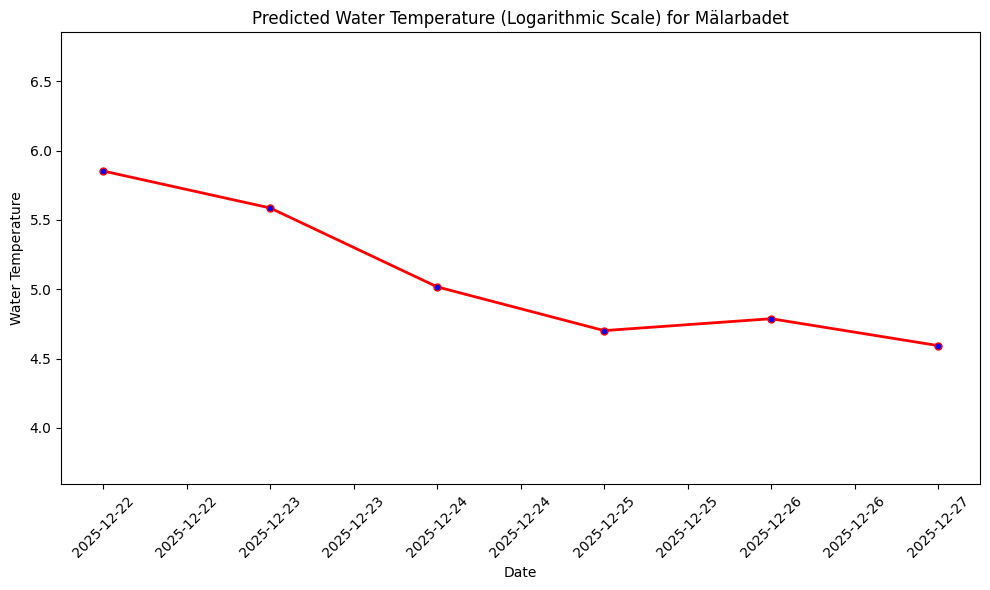

In [14]:



for batch_df in batch_data_frames:
    if batch_df["alias"].size == 0:
        continue
    place_code = batch_df['alias'][0]
    print(place_code)
    bath_name = CODE_TO_BATH[place_code]
    #batch_df["alias"] = bath_name

    print(bath_name)
    pred_file_path = f"{root_dir}/docs/water-temp/water-temp_{bath_name}/assets/img/water_temp_forecast_{bath_name}.png"
    plt = util.plot_water_temp_forecast(bath_name, batch_df, pred_file_path)

    plt.show()

In [15]:
# Get or create feature group

#Select version of feature group

m_version = 1


monitor_fg = fs.get_or_create_feature_group(
    name='wt_predictions',
    description='Water Temperature prediction monitoring',
    version=m_version,
    primary_key=['alias','formatted_time','days_before_forecast_day'],
    event_time="formatted_time"
)

In [16]:

all_data_frames = None
for frame in batch_data_frames:
    if all_data_frames is None:
        all_data_frames = frame
    else:
        all_data_frames = pd.concat([all_data_frames,frame], ignore_index=True)
monitor_fg.insert(all_data_frames, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-21 21:44:24,058 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-12-21 21:44:27,261 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-12-21 21:44:30,458 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-21 21:46:25,580 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-21 21:46:25,756 INFO: Waiting for log aggregation to finish.
2025-12-21 21:46:44,532 INFO: Execution finished successfully.


(Job('wt_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [17]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.99s) 


,formatted_time,alias,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,latitude,longitude,days_before_forecast_day,lagged_wt_1_day,lagged_wt_2_days,lagged_wt_3_days,predicted_temp_water
0,2025-12-22 12:00:00+00:00,4,0.95,0.0,9.826088,351.57312,59.222657,17.611886,1,5.9,6.0,6.1,5.853065


In [18]:
#Select version of feature group

wt_version = 1
    
water_temperature_fg = fs.get_feature_group(name='water_temperature', version=wt_version)
water_temperature_df = water_temperature_fg.read()
water_temperature_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 


,formatted_time,alias,temp_water,longitude,latitude,lagged_wt_1_day,lagged_wt_2_days,lagged_wt_3_days
0,2025-02-27 13:53:00+00:00,Åbynäsbadet,2.0,17.619576,59.018397,1.9,1.7,1.7
1,2022-10-26 10:40:00+00:00,Eklundsnäsbadet,8.3,17.591840,59.168830,11.3,8.4,5.3
2,2022-07-22 11:44:00+00:00,Bränningestrand,20.8,17.667400,59.148617,20.4,18.9,18.8
3,2022-12-11 10:11:00+00:00,Farstanäsbadet,3.9,17.653870,59.096884,4.0,5.0,4.4
4,2024-06-30 14:45:00+00:00,Farstanäsbadet,20.2,17.653870,59.096884,21.4,21.4,21.0
...,...,...,...,...,...,...,...,...
7407,2023-02-13 09:49:00+00:00,Eklundsnäsbadet,3.6,17.591840,59.168830,3.4,3.3,3.0
7408,2024-02-22 10:17:00+00:00,Eklundsnäsbadet,2.5,17.591840,59.168830,2.6,2.5,2.5
7409,2025-12-19 13:36:00+00:00,Mälarbadet,6.1,17.611886,59.222657,6.0,6.1,6.1
7410,2025-12-20 13:36:00+00:00,Mälarbadet,6.0,17.611886,59.222657,6.1,6.1,6.2


In [52]:
def backfill_predictions_for_monitoring(weather_fg, water_temp_df, monitor_fg, model):
    features_df = weather_fg.read()
    features_df["alias"] = features_df["alias"].map(BATH_TO_CODE).astype("Int64")

    print(features_df)
    all_features_df = pd.merge(
        water_temp_df[['lagged_wt_1_day','lagged_wt_2_days', 'lagged_wt_3_days', 'formatted_time', 'alias']],
        features_df[['temperature_2m', 'precipitation', 'wind_speed_10m', 'wind_direction_10m', 'latitude', 'longitude', 'formatted_time', 'alias']],
        on=['formatted_time', 'alias'],
    )
    all_features_df = all_features_df.sort_values(by=['formatted_time'], ascending=True)
    all_features_df = all_features_df.tail(10)



    #street = water_temp_df.iloc[0]['alias']
    #all_features_df.rename(columns={'temperature_2m_mean' : 'weather_temperature_2m_mean', 'precipitation_sum' : 'weather_precipitation_sum','wind_speed_10m_max' : 'weather_wind_speed_10m_max', 'wind_direction_10m_dominant' : 'weather_wind_direction_10m_dominant'}, inplace=True)

    X = all_features_df[[
        "alias",
        "lagged_wt_1_day", "lagged_wt_2_days", "lagged_wt_3_days",
        "temperature_2m", "precipitation", "wind_speed_10m", "wind_direction_10m",
    ]]



    all_features_df['predicted_temp_water'] = model.predict(X)
    
    df = pd.merge(all_features_df, water_temp_df[['formatted_time','temp_water','alias']], on=["formatted_time", "alias"])
    df['days_before_forecast_day'] = 1
    hindcast_df = df
    df = df.drop('temp_water', axis=1)
    df
       
    monitor_fg.insert(df, write_options={"wait_for_job": True})

    return hindcast_df
    



In [53]:




outcome_df = water_temperature_df[['formatted_time', 'temp_water', 'alias']]
#print()
outcome_df["alias"] = outcome_df["alias"].map(BATH_TO_CODE)
preds_df =  monitoring_df[['formatted_time', 'predicted_temp_water', 'alias']]

hindcast_df = pd.merge(preds_df, outcome_df, on=['formatted_time', 'alias'])    
    
hindcast_dfs = []
for location in bath_locations:
        print(location)
        sensor_hindcast_df = hindcast_df[hindcast_df['alias'] == location['bath_location']]
        sensor_wt_df = water_temperature_df[water_temperature_df['alias'] == location['bath_location']]
        sensor_wt_df["alias"] = BATH_TO_CODE[location["bath_location"]]
        
        sensor_hindcast_df = sensor_hindcast_df.sort_values(by=['formatted_time'])

        # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
        if len(sensor_hindcast_df) == 0:
            print(sensor_wt_df)
            sensor_hindcast_df = backfill_predictions_for_monitoring(weather_fg, sensor_wt_df, monitor_fg, retrieved_xgboost_model)
        
        hindcast_dfs.append(sensor_hindcast_df)

#hindcast_dfs[1]

2025-12-21 22:12:13,567 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

{'bath_location': 'Bergabadet', 'latitude': 59.057008, 'longitude': 17.440774}
2025-12-21 22:12:13,583 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

                formatted_time  alias  temp_water  longitude   latitude  \
11   2024-06-15 14:28:00+00:00      0        18.5  17.440774  59.057008   
12   2023-01-01 10:01:00+00:00      0         2.4  17.440774  59.057008   
41   2022-08-18 12:04:00+00:00      0        23.3  1

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-21 22:12:32,235 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-12-21 22:12:38,647 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-21 22:14:40,592 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-21 22:14:40,769 INFO: Waiting for log aggregation to finish.
2025-12-21 22:15:03,021 INFO: Execution finished successfully.
{'bath_location': 'Bränningestrand', 'latitude': 59.148617, 'longitude': 17.6674}
2025-12-21 22:15:03,032 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-21 22:15:21,659 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-12-21 22:15:28,070 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-21 22:17:33,397 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-21 22:17:33,567 INFO: Waiting for log aggregation to finish.
2025-12-21 22:17:56,259 INFO: Execution finished successfully.
{'bath_location': 'Eklundsnäsbadet', 'latitude': 59.16883, 'longitude': 17.59184}
2025-12-21 22:17:56,265 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-21 22:18:14,859 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-12-21 22:18:18,067 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-21 22:20:16,953 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-12-21 22:20:20,191 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-21 22:20:20,360 INFO: Waiting for log aggregation to finish.
2025-12-21 22:20:46,090 INFO: Execution finished successfully.
{'bath_location': 'Farstanäsbadet', 'latitude': 59.096884, 'longitude': 17.65387}
2025-12-21 22:20:46,096 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-21 22:21:04,722 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-12-21 22:21:14,381 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-21 22:23:10,234 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-21 22:23:10,411 INFO: Waiting for log aggregation to finish.
2025-12-21 22:23:32,721 INFO: Execution finished successfully.
{'bath_location': 'Mälarbadet', 'latitude': 59.222657, 'longitude': 17.611886}
2025-12-21 22:23:32,727 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-21 22:23:51,760 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-12-21 22:23:54,985 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-21 22:26:03,548 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-21 22:26:03,743 INFO: Waiting for log aggregation to finish.
2025-12-21 22:26:23,026 INFO: Execution finished successfully.
{'bath_location': 'Nya Malmsjöbadet', 'latitude': 59.234823, 'longitude': 17.536534}
2025-12-21 22:26:23,032 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-21 22:26:42,003 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-12-21 22:26:45,219 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-21 22:28:28,347 INFO: Waiting for log aggregation to finish.
2025-12-21 22:28:50,676 INFO: Execution finished successfully.
{'bath_location': 'Näsets udde(Glashyttan)', 'latitude': 59.158419, 'longitude': 17.66072}
2025-12-21 22:28:50,682 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

    

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-21 22:29:09,923 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-12-21 22:29:13,130 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-21 22:31:12,658 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-12-21 22:31:15,857 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-21 22:31:16,019 INFO: Waiting for log aggregation to finish.
2025-12-21 22:31:34,875 INFO: Execution finished successfully.
{'bath_location': 'Underåsbadet', 'latitude': 59.26482, 'longitude': 17.536534}
2025-12-21 22:31:34,879 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-21 22:31:52,389 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-12-21 22:31:55,616 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-21 22:34:02,114 INFO: Waiting for log aggregation to finish.
2025-12-21 22:34:24,618 INFO: Execution finished successfully.
{'bath_location': 'Åbynäsbadet', 'latitude': 59.018397, 'longitude': 17.619576}
2025-12-21 22:34:24,624 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

               

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-21 22:34:43,699 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-12-21 22:34:50,213 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-21 22:36:40,217 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-21 22:36:40,397 INFO: Waiting for log aggregation to finish.
2025-12-21 22:37:02,749 INFO: Execution finished successfully.


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

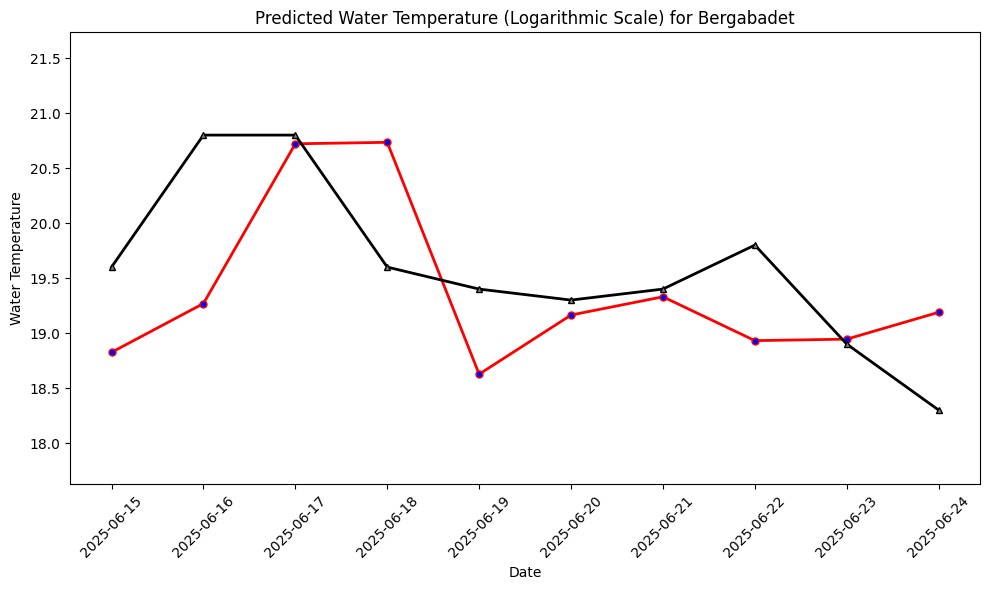

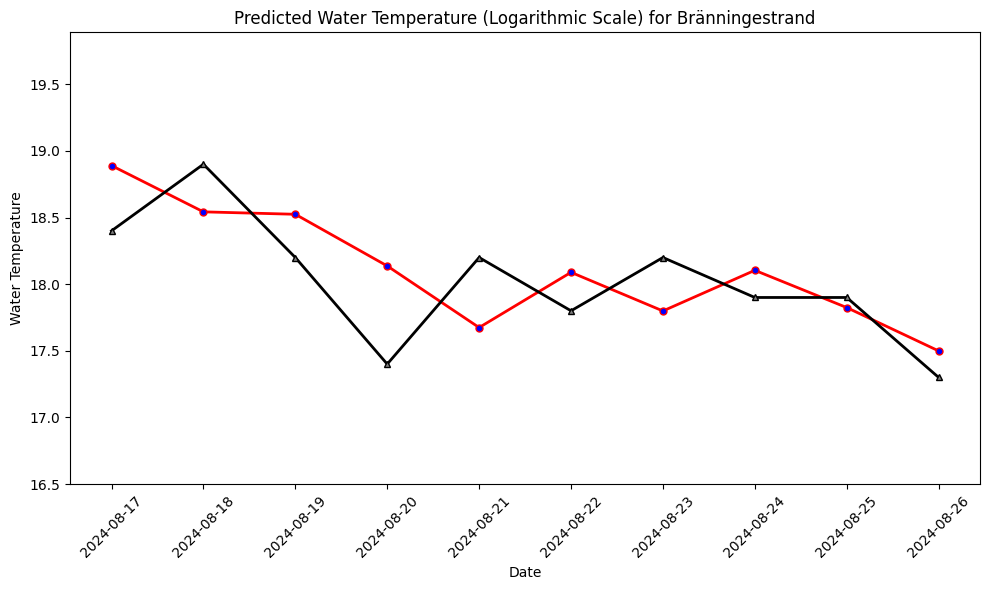

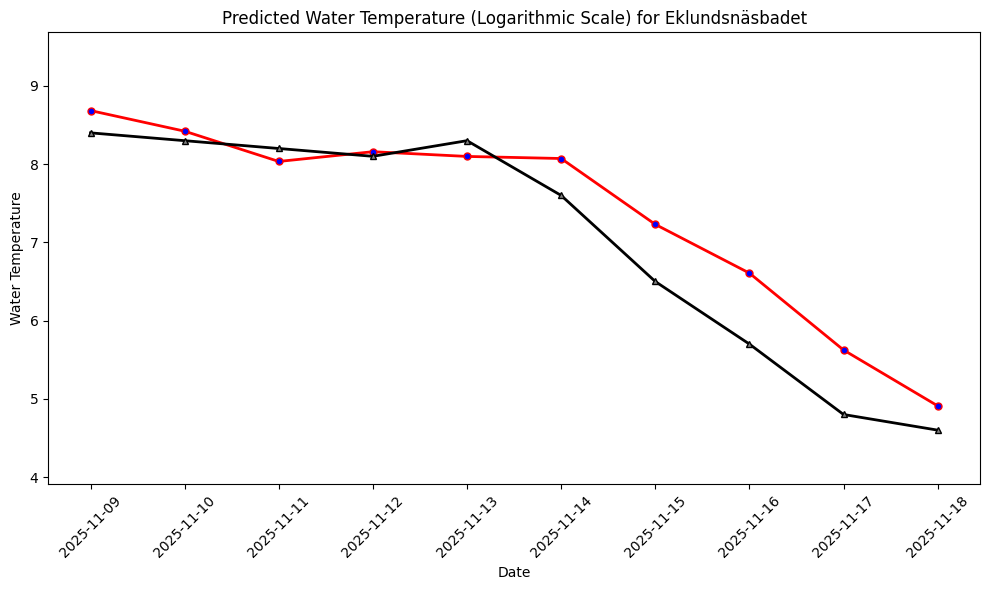

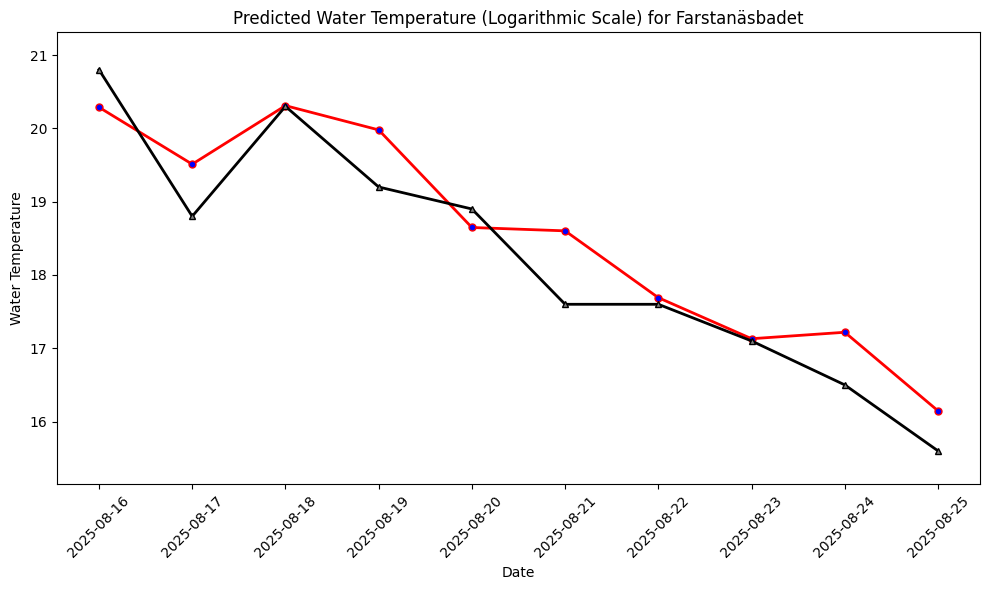

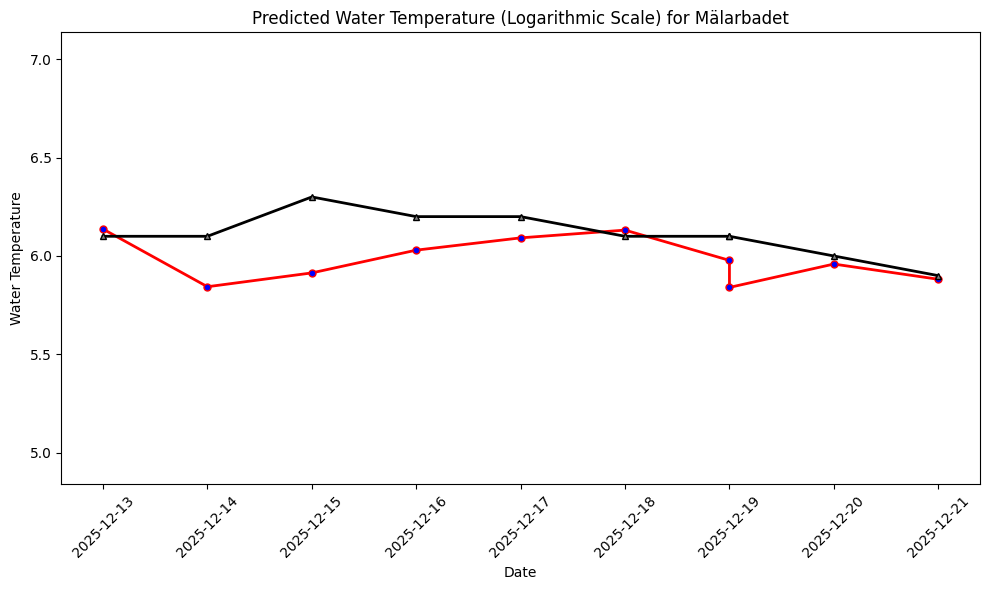

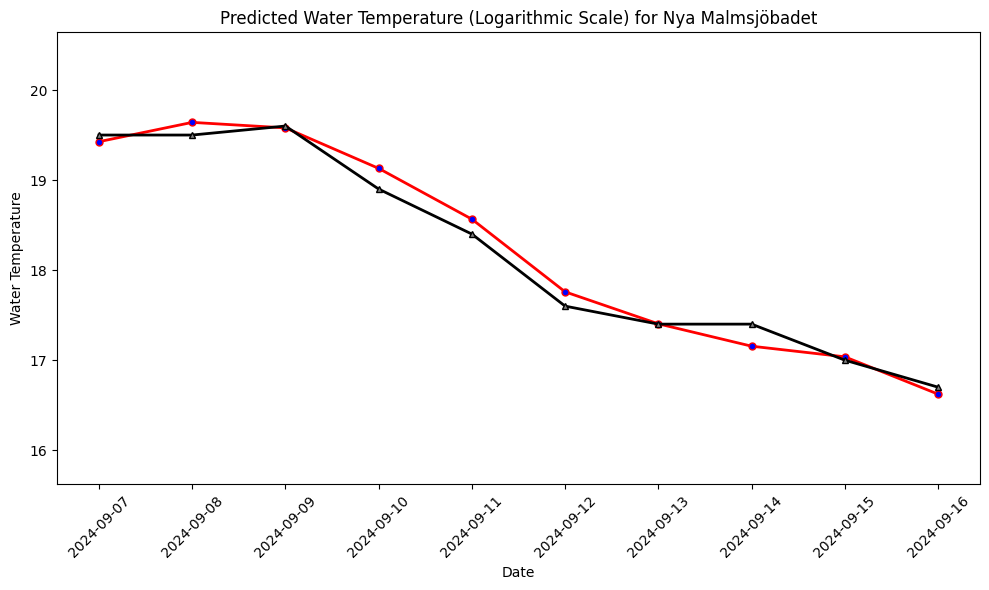

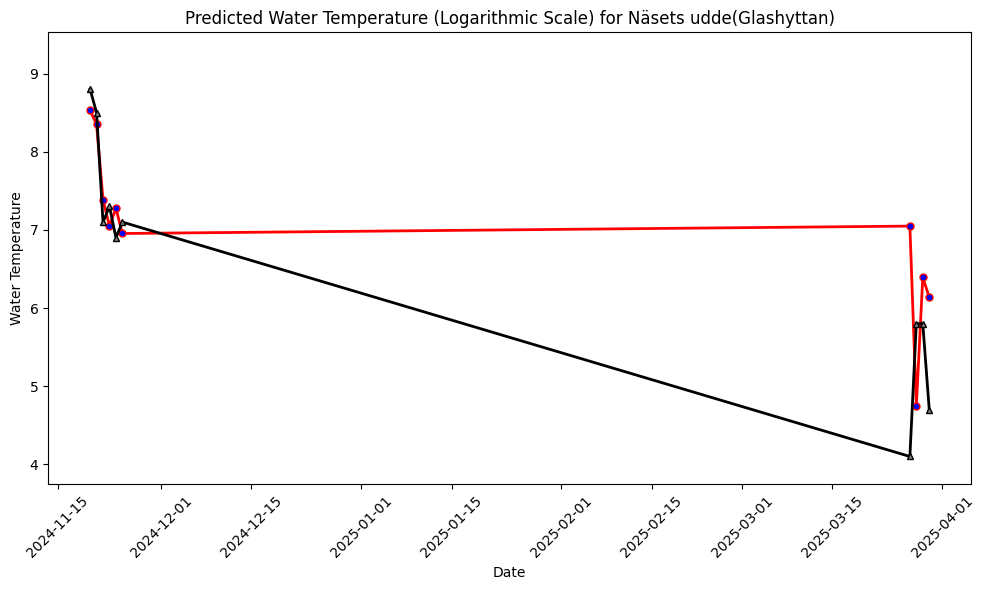

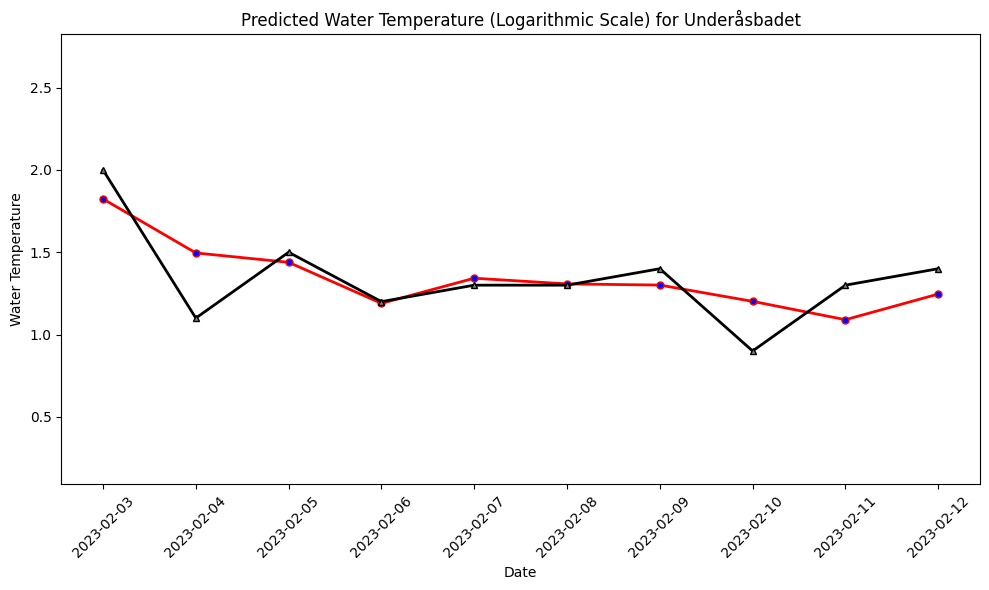

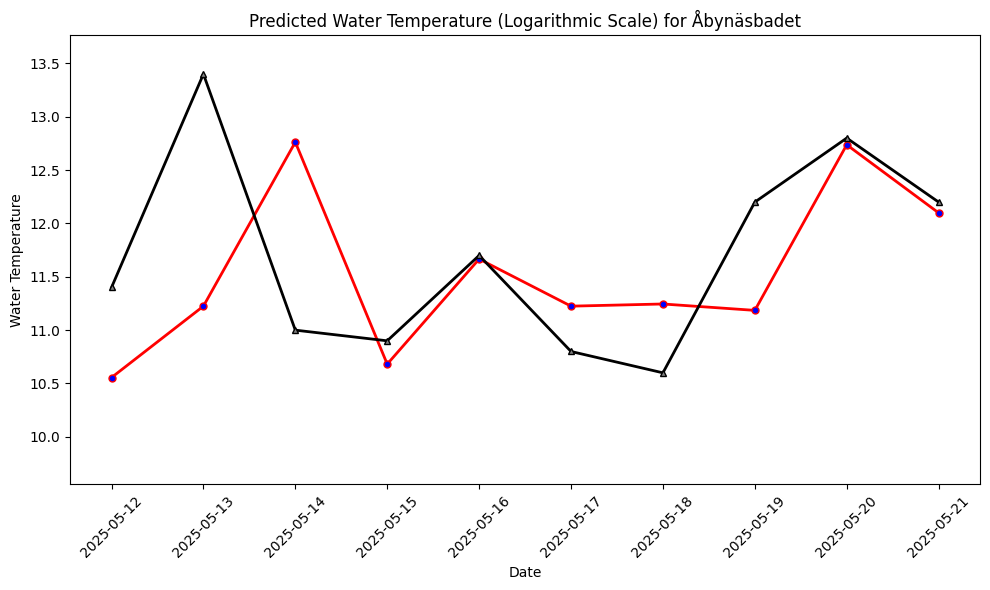

In [62]:


for h_df in hindcast_dfs:
        place_code = h_df.iloc[0]['alias']
        place = CODE_TO_BATH[place_code]
        hindcast_file_path = f"{root_dir}/docs/water-temp/water-temp_{place}/assets/img/water-temp_hindcast_1day_{place}.png"
        plt = util.plot_water_temp_forecast(place, h_df, hindcast_file_path, hindcast=True)
        plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/watertemp") == False:
    dataset_api.mkdir("Resources/watertemp")



for location in bath_locations:
        place = location['bath_location']
        try:
            dataset_api.upload(f"{root_dir}/docs/water-temp/water-temp_{place}/assets/img/water-temp_forecast_{place}.png", f"Resources/water-temp_{place}/{place}_{str_today}", overwrite=True)
            dataset_api.upload(f"{root_dir}/docs/water-temp/water-temp_{place}/assets/img/water-temp_hindcast_1day{place}.png", f"Resources/water-temp_{place}/{place}_{str_today}", overwrite=True)
        except FileNotFoundError:
             continue


proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/watertemp")

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286295/settings/fb/path/Resources/airquality


---